In [1]:
import pandas as pd
import numpy as np
import pathlib

from hydra import initialize, compose
from omegaconf import OmegaConf
initialize("./configs")

from utils.misc import get_items_on_path, plot_multiple_img
from utils.vision.transformation import get_image_and_reshape, rle_decode, transform_image_contrast
from utils.vision.plots import plot_image_with_annot

%matplotlib inline

In [2]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_TRAIN_IMAGE_FOLDER = pathlib.Path(cfg.project_setup.paths.data.TRAIN_IMAGE_FOLDER)
PATH_TRAIN_METADATA = pathlib.Path(cfg.project_setup.paths.data.TRAIN_METADATA)

print(OmegaConf.to_yaml(cfg))

project_setup:
  paths:
    data:
      TRAIN_IMAGE_FOLDER: ./data/train
      TRAIN_METADATA: ./data/train.csv
      PREPROCESSED_CACHE: ./data/preprocessed/X_y.npz
    model:
      MODEL_FOLDER: ./data/models
  RANDOM_STATE_N: 19
  tensorboard:
    SERVER_PORT: 6006
    LOG_DIR: logs
preprocessing:
  INPUT_SHAPE:
    HEIGHT: 520
    WIDTH: 704
  OUTPUT_SHAPE:
    HEIGHT: 512
    WIDTH: 704
  TRANS_POWER: 2
training:
  device:
    GPU: 1
  model:
    LEARNING_RATE: 0.0001
    VAL_SIZE: 0.1
    BATCH_SIZE: 4
    EPOCHS: 20
    PATIENCE: 6



In [3]:
# read data
train_metadata = pd.read_csv(PATH_TRAIN_METADATA)
train_metadata.head(2)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [4]:
# Explore the metadata
print(f"Shape of the train meta-data is: {train_metadata.shape}")
print(f"There is the following missing data: \n{train_metadata.isnull().sum()}")
print(f"Number of unique images: {train_metadata.id.nunique()}")
print(f"These are the cell types in the data: {list(train_metadata.cell_type.unique())}")

Shape of the train meta-data is: (73585, 9)
There is the following missing data: 
id                   0
annotation           0
width                0
height               0
cell_type            0
plate_time           0
sample_date          0
sample_id            0
elapsed_timedelta    0
dtype: int64
Number of unique images: 606
These are the cell types in the data: ['shsy5y', 'astro', 'cort']


In [5]:
# Explore the metadata in respect to the images (height and width)
train_metadata[["height", "width"]].describe()

,height,width
count,73585.0,73585.0
mean,520.0,704.0
std,0.0,0.0
min,520.0,704.0
25%,520.0,704.0
50%,520.0,704.0
75%,520.0,704.0
max,520.0,704.0


In [6]:
# Number of annotations per image
train_metadata.groupby("id")[["annotation"]].count().sort_values("annotation")

,annotation
id,
e92c56871769,4
eec79772cb99,5
b861811eaff6,5
c25db38e918e,6
7f21996da2e6,8
...,...
e8ae919aa92e,605
aff8fb4fc364,609
e748ac1c469b,703


Explore the images by loading them and displaying without and with the annotations

In [52]:
## load all train images into memory as dictionary with image_id as key
input_img_shape = (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH)

train_images_paths = get_items_on_path(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, input_img_shape) for train_image_path in train_images_paths]

train_data_dict = {
    image_id: {
        "X": {"image_raw": image, "X_transformed": None}, 
        "y": {"rle_raw": None, "y_transformed": None}
    } for image, image_id in train_images}

for image_id in train_data_dict:
    df_row=train_metadata[train_metadata["id"] == image_id]
    annots=df_row["annotation"].tolist()
    train_data_dict[image_id]["y"]["rle_raw"] = annots

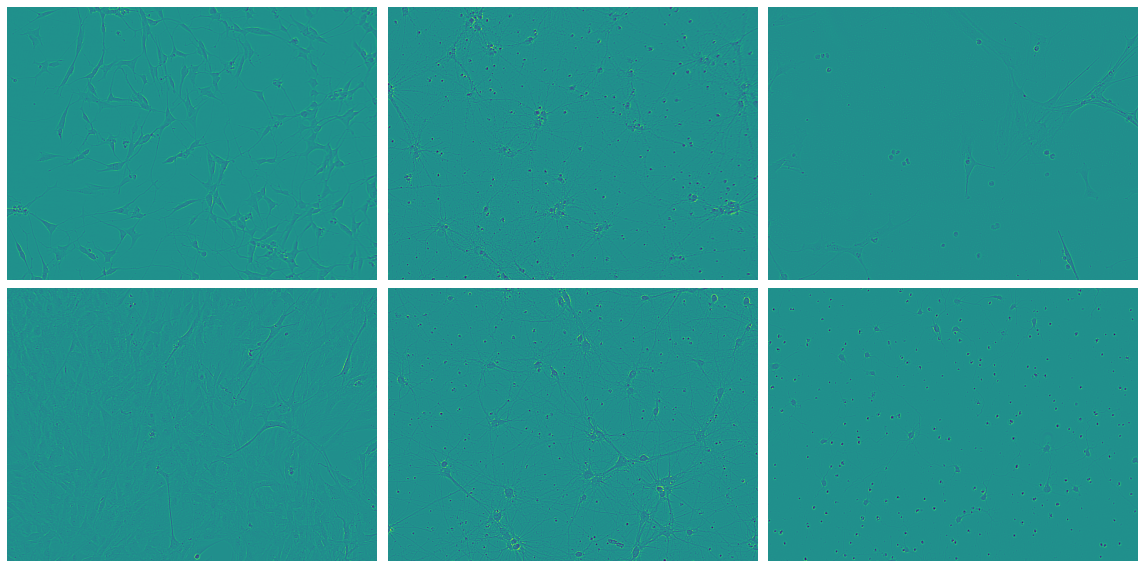

In [47]:
# Plot images without annotations
number_of_images = 6
cols = 3
rows = int(number_of_images/ cols)
selected_image_ids=list(train_images_dict.keys())[:number_of_images]
images = [train_data_dict[selected_image_ids[image_id]]["X"]["image_raw"] for image_id,_ in enumerate(selected_image_ids)]
plot_multiple_img(images, rows, cols)

## load all train images into memory as dictionary with image_id as key and the image (np.ndarray) as value
input_img_shape = (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH)

train_images_paths = get_items_on_path(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, input_img_shape) for train_image_path in train_images_paths]
train_images_dict = {image_id: {"image_raw": image} for image, image_id in train_images}

# Plot images without annotations
number_of_images = 6
cols = 3
rows = int(number_of_images/ cols)
images = list(train_images_dict.values())[:number_of_images]
plot_multiple_img(images, rows, cols)

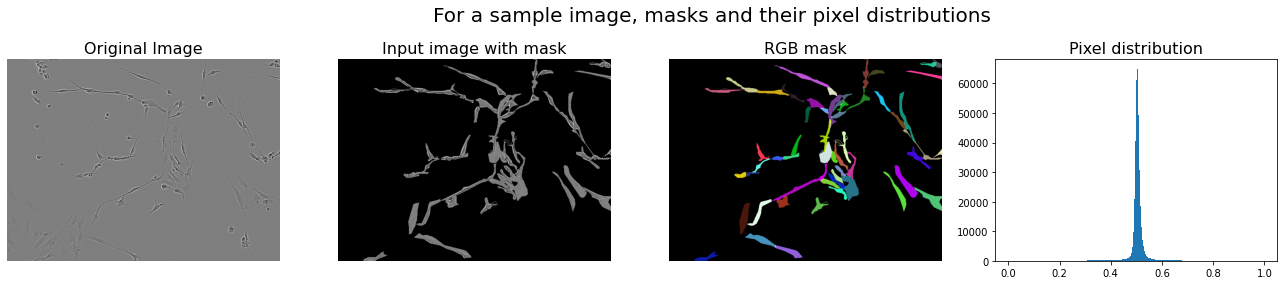

In [55]:
# Plot random image with annotations and pixel distributions
rnd_int=np.random.randint(len(train_data_dict))
rnd_image_id=list(train_data_dict.keys())[rnd_int]
image=train_data_dict[rnd_image_id]["X"]["image_raw"]
annots=train_data_dict[rnd_image_id]["y"]["rle_raw"]


plot_image_with_annot(image, annots, img_2d_shape=input_img_shape)

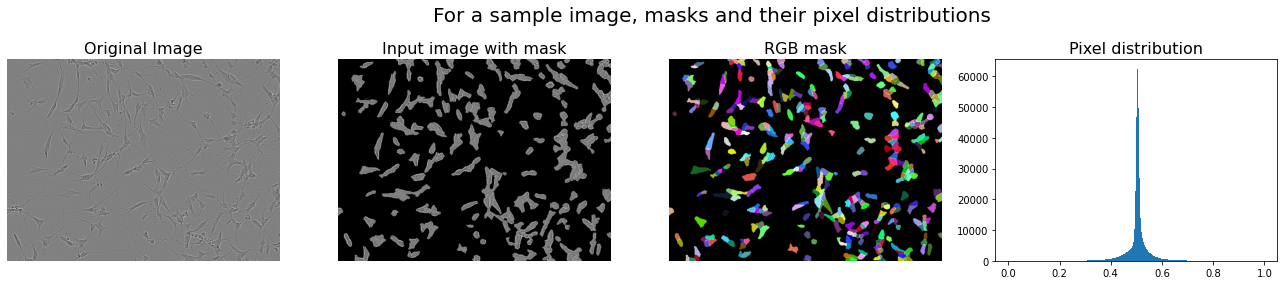

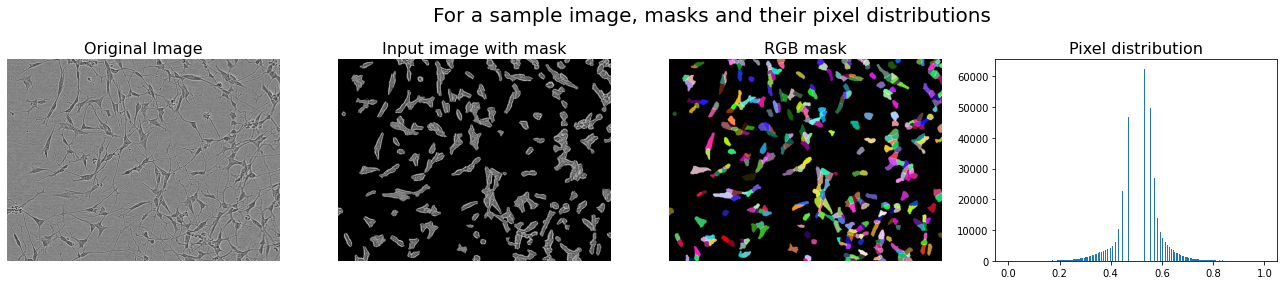

In [56]:
image_id = "b89f9cca5384"
image=train_data_dict[image_id]["X"]["image_raw"]
image_transformed=transform_image_contrast(image, power=cfg.preprocessing.TRANS_POWER)

annots=train_data_dict[image_id]["y"]["rle_raw"]
plot_image_with_annot(image, annots, img_2d_shape=input_img_shape, normalize_hist=True)
plot_image_with_annot(image_transformed, annots, img_2d_shape=input_img_shape, normalize_hist=False)
